In [198]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import uniform
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import numpy as np

# Partie 1 — Fondamentaux de l'évaluation des modèles

In [28]:
df = pd.read_csv("tp_fil_rouge_data.csv", encoding="ISO-8859-1")

print(df.head())
print(f"\nShape       : {df.shape}")
print(f"\nValeurs manquantes :\n{df.isnull().sum()}")
print(f"\nDoublons    : {df.duplicated().sum()}")

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Shape       : (541909, 8)

Valeurs manquantes :
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country   

## Création de la target

In [29]:
df.dropna(subset=["CustomerID"], inplace=True)

df.drop_duplicates(inplace=True)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# La date de référence = la date la plus récente du dataset
snapshot_date = df["InvoiceDate"].max()

last_purchase = (
    df.groupby("CustomerID")["InvoiceDate"]
    .max()
    .reset_index()
    .rename(columns={"InvoiceDate": "LastPurchase"})
)

last_purchase["churn"] = (
    (snapshot_date - last_purchase["LastPurchase"]).dt.days > 90
).astype(int)

print(last_purchase["churn"].value_counts())

churn
0    2922
1    1450
Name: count, dtype: int64


In [30]:
dataset = (
    df.groupby("CustomerID")
    .agg(
        nb_commandes=("InvoiceNo", "nunique"),
        nb_produits=("StockCode", "nunique"),
        montant_total=("Quantity", lambda x: (x * df.loc[x.index, "UnitPrice"]).sum()),
        pays=("Country", "first"),
    )
    .reset_index()
    .merge(last_purchase[["CustomerID", "churn"]], on="CustomerID")
)

In [31]:
X = dataset.drop(columns=["CustomerID", "churn"])
y = dataset["churn"]

## Split train/test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original       : {np.bincount(y) / len(y)}")
print(f"Simple - Train : {np.bincount(y_train) / len(y_train)}")
print(f"Simple - Test  : {np.bincount(y_test) / len(y_test)}")
print(f"Strat  - Train : {np.bincount(y_train_s) / len(y_train_s)}")
print(f"Strat  - Test  : {np.bincount(y_test_s) / len(y_test_s)}")

Original       : [0.66834401 0.33165599]
Simple - Train : [0.66571347 0.33428653]
Simple - Test  : [0.67885714 0.32114286]
Strat  - Train : [0.6682871 0.3317129]
Strat  - Test  : [0.66857143 0.33142857]


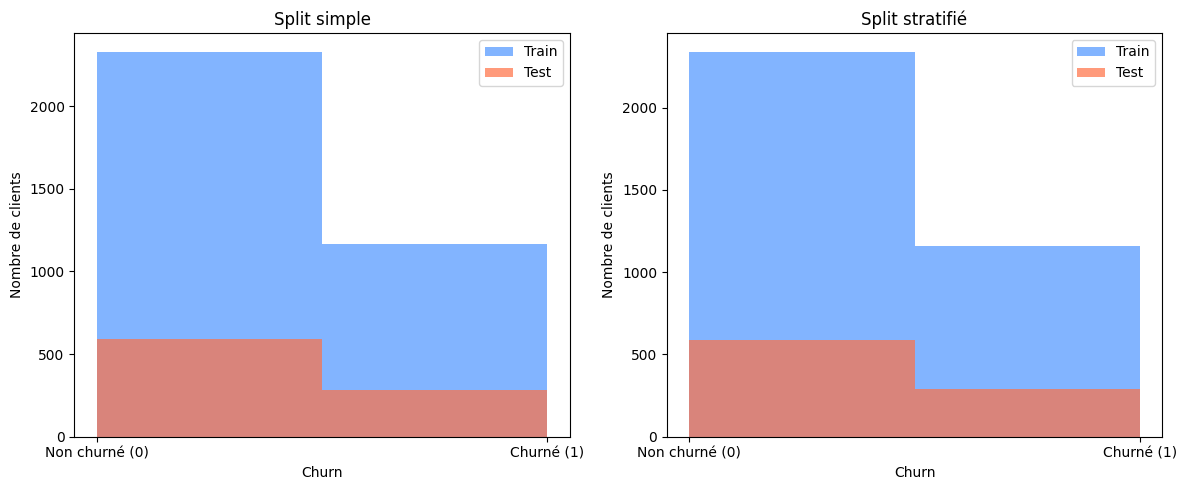

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, y_tr, y_te, title in zip(
    axes, [y_train, y_train_s], [y_test, y_test_s], ["Split simple", "Split stratifié"]
):
    ax.hist(y_tr, bins=2, alpha=0.7, label="Train", color="#4d94ff")
    ax.hist(y_te, bins=2, alpha=0.7, label="Test", color="#ff7043")
    ax.set_title(title)
    ax.set_xlabel("Churn")
    ax.set_ylabel("Nombre de clients")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Non churné (0)", "Churné (1)"])
    ax.legend()

plt.tight_layout()
plt.show()

In [34]:
num_features = ["nb_commandes", "nb_produits", "montant_total"]
cat_features = ["pays"]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            num_features,
        ),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    (
                        "encoder",
                        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                    ),
                ]
            ),
            cat_features,
        ),
    ]
)

full_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        ),
    ]
)

## Cross-validation

In [35]:
METRICS = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

pipelines = {
    name: Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
    for name, clf in models.items()
}


In [36]:
kf_scores = {}
skf_scores = {}
for name, pipeline in pipelines.items():
    s_kf = cross_val_score(pipeline, X, y, cv=kf, scoring="accuracy", n_jobs=-1)
    s_skf = cross_val_score(pipeline, X, y, cv=skf, scoring="accuracy", n_jobs=-1)
    kf_scores[name] = s_kf
    skf_scores[name] = s_skf
    print(
        f"{name} : Kfold : moyenne : {s_kf.mean()} std : {s_kf.std()} | stratified : moyenne : {s_skf.mean()} std : {s_skf.std()}"
    )

LogisticRegression : Kfold : moyenne : 0.7172898332788493 std : 0.009959078854460625 | stratified : moyenne : 0.7156877410918601 std : 0.008082588321346649
DecisionTree : Kfold : moyenne : 0.6438713305001634 std : 0.016096420362764333 | stratified : moyenne : 0.638381954887218 std : 0.007465562848881208
RandomForest : Kfold : moyenne : 0.6804670807453416 std : 0.009433671750610835 | stratified : moyenne : 0.6731462569467146 std : 0.013195543175925075
GradientBoosting : Kfold : moyenne : 0.7065396534815299 std : 0.012937059447515845 | stratified : moyenne : 0.7037936580581889 std : 0.00982945382680401


In [37]:
cv_results = {}
for name, pipeline in pipelines.items():
    print(f"  cross_validate : {name}...")
    cv_results[name] = cross_validate(
        pipeline, X, y, cv=skf, scoring=METRICS, return_train_score=True, n_jobs=-1
    )


summary = []
for name, res in cv_results.items():
    acc = res["test_accuracy"].mean()
    f1 = res["test_f1_macro"].mean()
    prec = res["test_precision_macro"].mean()
    rec = res["test_recall_macro"].mean()
    summary.append(
        {"name": name, "accuracy": acc, "f1": f1, "precision": prec, "recall": rec}
    )
    print(f"{name} accuracy : {acc} f1 : {f1} precision : {prec} recall : {rec}")

best = max(summary, key=lambda x: x["f1"])
print(best)

  cross_validate : LogisticRegression...
  cross_validate : DecisionTree...
  cross_validate : RandomForest...
  cross_validate : GradientBoosting...
LogisticRegression accuracy : 0.7156877410918601 f1 : 0.6650250013114146 precision : 0.6759343111294847 recall : 0.6599667627549064
DecisionTree accuracy : 0.638381954887218 f1 : 0.5947282964690946 precision : 0.594250208372642 recall : 0.5953614209754975
RandomForest accuracy : 0.6731462569467146 f1 : 0.6143678461392887 precision : 0.6226911153958368 recall : 0.6109467921466032
GradientBoosting accuracy : 0.7037936580581889 f1 : 0.6484598249202063 precision : 0.6608883156235285 recall : 0.6434244859481042
{'name': 'LogisticRegression', 'accuracy': np.float64(0.7156877410918601), 'f1': np.float64(0.6650250013114146), 'precision': np.float64(0.6759343111294847), 'recall': np.float64(0.6599667627549064)}


(0.0, 1.05)

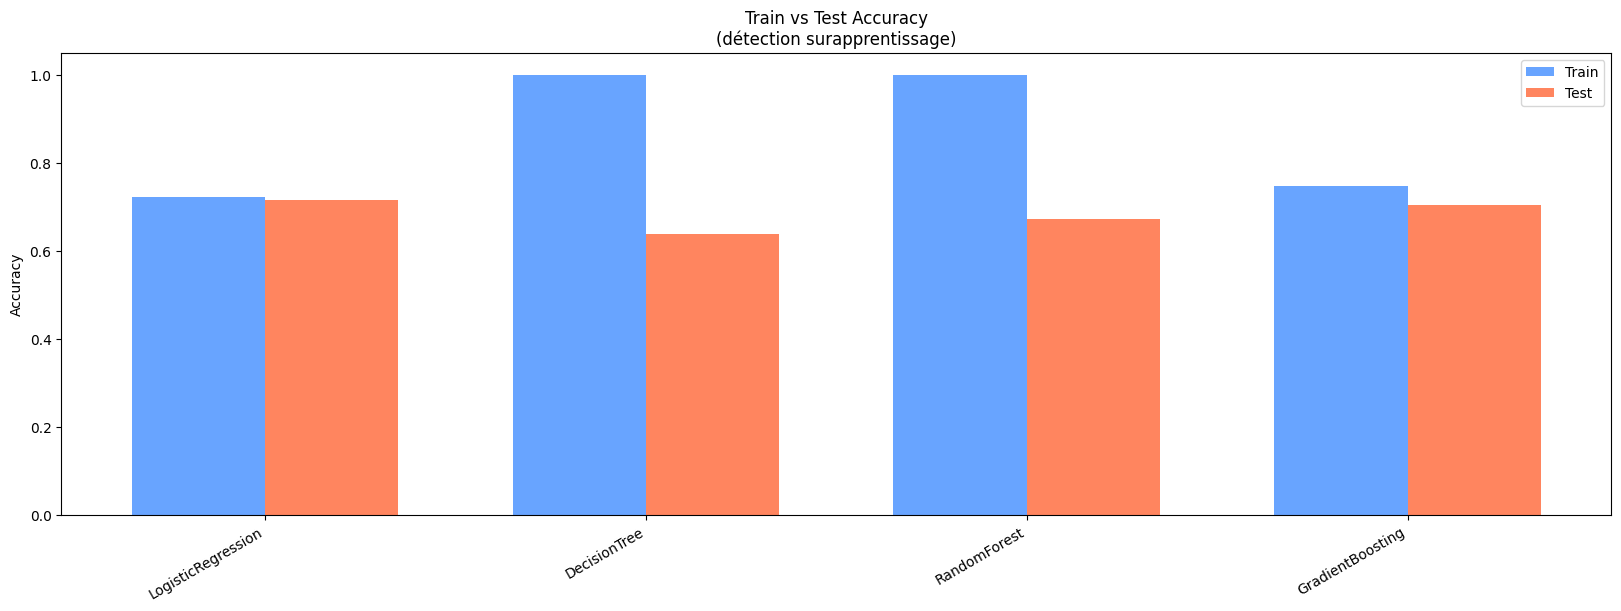

In [38]:
names = list(cv_results.keys())

fig, axes = plt.subplots(1, 1, figsize=(20, 6))

x2, w2 = np.arange(len(names)), 0.35
train_scores = [cv_results[n]["train_accuracy"].mean() for n in names]
test_scores = [cv_results[n]["test_accuracy"].mean() for n in names]
axes.bar(x2 - w2 / 2, train_scores, w2, label="Train", color="#4d94ff", alpha=0.85)
axes.bar(x2 + w2 / 2, test_scores, w2, label="Test", color="#ff7043", alpha=0.85)
axes.set_xticks(x2)
axes.set_xticklabels(names, rotation=30, ha="right")
axes.set_ylabel("Accuracy")
axes.set_title("Train vs Test Accuracy\n(détection surapprentissage)")
axes.legend()
axes.set_ylim(0, 1.05)

# Partie 2 — Optimisation des hyperparamètres

## RandomizedSearchCV

### Mise en place

1. Reprenez la pipeline complète (preprocessor + modèle) identifiée à la partie précédente.
2. Définissez un espace de recherche large pour les hyperparamètres du modèle.

In [143]:
lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=500, random_state=42)),
    ]
)

param_distributions = {
    "classifier__C": uniform(0.1, 10),
    "classifier__penalty": [
        # "l1",
        "l2",
        # "elasticnet",
    ],
    "classifier__solver": [
        "lbfgs",
        "liblinear",
        "newton-cg",
        "newton-cholesky",
        "sag",
        "saga",
    ],
    "classifier__fit_intercept": [True, False],
    "classifier__class_weight": ["balanced", None],
}

3. Instanciez un `RandomizedSearchCV` avec :
   - `n_iter=20` (nombre de combinaisons testées)
   - une `StratifiedKFold` à 5 folds comme stratégie de validation
   - le F1-score macro comme métrique de scoring
   - `random_state=42` pour la reproductibilité

In [168]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv=skf,
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
)

4. Entraînez la recherche sur le jeu d'entraînement et mesurez le temps d'exécution avec `time.time()`.

In [ ]:
random_search_t0 = time.time()
random_search.fit(X_train_s, y_train_s)
random_search_t1 = time.time()

c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [170]:
print("Temps d'éxécution : ", random_search_t1 - random_search_t0)

Temps d'éxécution :  2.3478903770446777


### Analyse des résultats

5. Affichez les meilleurs hyperparamètres trouvés et le meilleur score de validation croisée associé.

In [171]:
print("Meilleur hyperparamètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)

Meilleur hyperparamètres :  {'classifier__C': np.float64(6.274815096277165), 'classifier__class_weight': None, 'classifier__fit_intercept': False, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
Meilleur score :  0.6742162620409131


6. Récupérez le `cv_results_` et visualisez la distribution des scores F1 obtenus selon les différentes combinaisons testées (histogramme ou scatter plot `mean_test_score` vs rang).

In [172]:
results = pd.DataFrame(random_search.cv_results_)

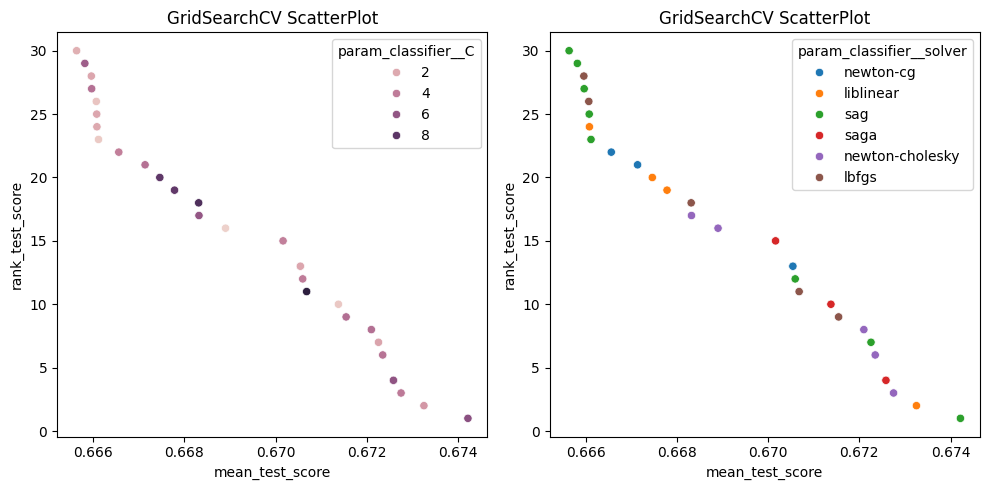

In [197]:
l2_results = results[results["param_classifier__penalty"] == "l2"].copy()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax1 = axes[0]
sns.scatterplot(
    x=l2_results["mean_test_score"],
    y=l2_results["rank_test_score"],
    hue=l2_results["param_classifier__C"],
    ax=ax1,
)
ax1.set_xlabel("mean_test_score")
ax1.set_ylabel("rank_test_score")
ax1.set_title("GridSearchCV ScatterPlot")

ax2 = axes[1]
sns.scatterplot(
    x=l2_results["mean_test_score"],
    y=l2_results["rank_test_score"],
    hue=l2_results["param_classifier__solver"],
    ax=ax2,
)
ax2.set_xlabel("mean_test_score")
ax2.set_ylabel("rank_test_score")
ax2.set_title("GridSearchCV ScatterPlot")

plt.tight_layout()
plt.show()

7. Évaluez le meilleur modèle sur le jeu de test et affichez le classification report complet.

In [174]:
best_model_random_search = random_search.best_estimator_

y_pred_random_search = best_model_random_search.predict(X_test)

print(classification_report(y_test, y_pred_random_search))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       594
           1       0.56      0.54      0.55       281

    accuracy                           0.71       875
   macro avg       0.67      0.67      0.67       875
weighted avg       0.71      0.71      0.71       875



## GridSearchCV

### Mise en place

1. À partir des meilleurs hyperparamètres trouvés par RandomizedSearch, **affinez l'espace de recherche** en définissant une grille restreinte autour de ces valeurs.

In [189]:
param_grid = {
    "classifier__C": [5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5],
    "classifier__penalty": [
        # "l1",
        "l2",
        # "elasticnet",
    ],
    "classifier__solver": [
        "liblinear",
        "sag",
    ],
    "classifier__class_weight": [None],
    "classifier__fit_intercept": [False],
}

2. Instanciez un `GridSearchCV` avec la même `StratifiedKFold` à 5 folds et le même scoring F1 macro.

In [190]:
grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=skf,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)

3. Entraînez la recherche sur le jeu d'entraînement et mesurez le temps d'exécution.

In [191]:
grid_search_t0 = time.time()
grid_search.fit(X_train, y_train)
grid_search_t1 = time.time()

c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Analyse des résultats

4. Affichez les meilleurs hyperparamètres trouvés et le meilleur score de validation croisée associé.

In [192]:
print("Meilleur hyperparamètres : ", grid_search.best_params_)
print("Meilleur score : ", grid_search.best_score_)

Meilleur hyperparamètres :  {'classifier__C': 5.6, 'classifier__class_weight': None, 'classifier__fit_intercept': False, 'classifier__penalty': 'l2', 'classifier__solver': 'sag'}
Meilleur score :  0.6744674844681434


5. Évaluez le meilleur modèle sur le jeu de test et affichez le classification report complet.

In [ ]:
best_model_grid_search = grid_search.best_estimator_

y_pred_grid_search = best_model_grid_search.predict(X_test)

print(classification_report(y_test, y_pred_grid_search))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       594
           1       0.56      0.54      0.55       281

    accuracy                           0.71       875
   macro avg       0.67      0.67      0.67       875
weighted avg       0.71      0.71      0.71       875



## Comparaison RandomSearch vs GridSearch

### Tableau de synthèse

7. Construisez un tableau comparatif récapitulant pour chaque méthode : le meilleur score F1 en validation croisée, le score F1 sur le jeu de test, le nombre de combinaisons testées et le temps d'exécution.

| Méthode            | Meilleur F1 (CV) | F1 test | Combinaisons testées | Temps (s) |
| ------------------ | ---------------- | ------- | -------------------- | --------- |
| RandomizedSearchCV |                  |         |                      |           |
| GridSearchCV       |                  |         |                      |           |

In [194]:
synthesis = {
    "Méthode": ["RandomizedSearchCV", "GridSearchCV"],
    "Meilleur F1 (CV)": [random_search.best_score_, grid_search.best_score_],
    "Meilleur Paramètres (CV)": [random_search.best_params_, grid_search.best_params_],
    "Temps (CV)": [
        random_search_t1 - random_search_t0,
        grid_search_t1 - grid_search_t0,
    ],
}

synthesis_df = pd.DataFrame(synthesis)
synthesis_df.head()

,Méthode,Meilleur F1 (CV),Meilleur Paramètres (CV),Temps (CV)
0,RandomizedSearchCV,0.674216,"{'classifier__C': 6.274815096277165, 'classifi...",2.347890
1,GridSearchCV,0.674467,"{'classifier__C': 5.6, 'classifier__class_weig...",2.055226


### Visualisation

8. Tracez un graphique en barres côte à côte comparant le F1-score en validation croisée et sur le jeu de test pour les deux méthodes.

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_24700\2650286466.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplt1 = sns.barplot(
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_24700\2650286466.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplt2 = sns.barplot(


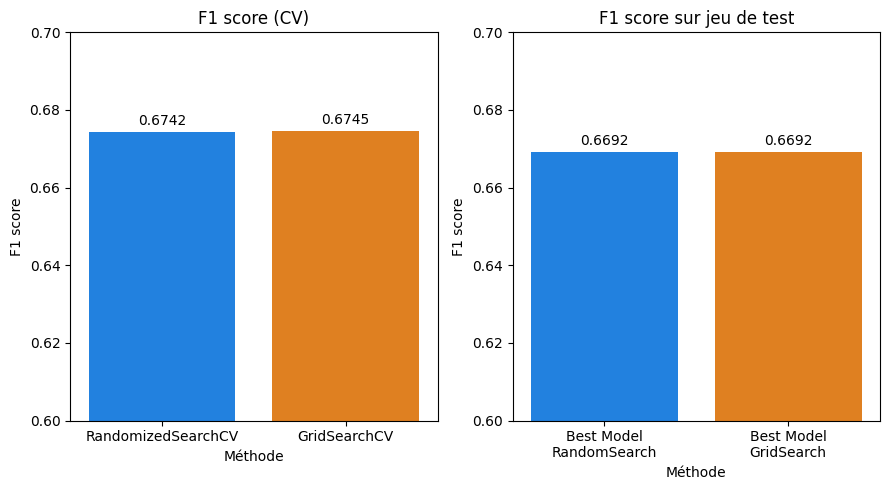

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

barplt1 = sns.barplot(
    synthesis_df,
    y="Meilleur F1 (CV)",
    x="Méthode",
    palette=["#0281FF", "#FF8001"],
    ax=axes[0],
)
axes[0].set_title("F1 score (CV)")
axes[0].set_ylabel("F1 score")
axes[0].set_xlabel("Méthode")
axes[0].set_ylim(0.6, 0.7)
for container in barplt1.containers:
    barplt1.bar_label(container, fmt="%.4f", padding=3)

barplt2 = sns.barplot(
    y=[
        f1_score(y_test, y_pred_random_search, average="macro"),
        f1_score(y_test, y_pred_grid_search, average="macro"),
    ],
    x=["Best Model\nRandomSearch", "Best Model\nGridSearch"],
    palette=["#0281FF", "#FF8001"],
    ax=axes[1],
)
axes[1].set_title("F1 score sur jeu de test")
axes[1].set_ylabel("F1 score")
axes[1].set_xlabel("Méthode")
axes[1].set_ylim(0.6, 0.7)
for container in barplt2.containers:
    barplt2.bar_label(container, fmt="%.4f", padding=3)

plt.tight_layout()